In [1]:
from astropy.io import fits
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import numpy as np
import scipy.optimize as so
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.patches as mpatches
from matplotlib.lines import Line2D
from matplotlib import cm
from matplotlib.colors import LogNorm

matplotlib.rcParams.update({'font.family':'cmr10','font.size': 13})
matplotlib.rcParams['axes.unicode_minus']=False
matplotlib.rcParams['axes.labelsize']=15
plt.rcParams['figure.figsize']=(4,4)



plt.rcParams['figure.dpi'] = 80
plt.rcParams['mathtext.fontset'] = 'cm'
plt.rcParams['mathtext.rm'] = 'serif'
plt.rcParams['xtick.direction'] = 'in'
plt.rcParams['ytick.direction'] = 'in'
plt.rcParams['xtick.top'] = True
plt.rcParams['ytick.right'] = True

In [37]:
def find_confidence_interval(x, pdf, confidence_level, area, sigma_string):
    return pdf[pdf > x].sum() - confidence_level

def density_contour(xdata, ydata, xbins2d,ybins2d, ax=None,pred = True, **contour_kwargs):
    
    H, xedges, yedges = np.histogram2d(xdata, ydata, bins=[xbins2d,ybins2d], range = [[xbins2d.min(),xbins2d.max()],[ybins2d.min(),ybins2d.max()]],density=True)
    xcenters = (xedges[1:]+ xedges[:-1])/2
    ycenters = (yedges[1:]+ yedges[:-1])/2
    x_bin_sizes = (xedges[1:] - xedges[:-1]).reshape((1,len(xcenters)))
    y_bin_sizes = (yedges[1:] - yedges[:-1]).reshape((len(ycenters),1))
    area = (x_bin_sizes*y_bin_sizes)
    #print(area)
    pdf = (H*(x_bin_sizes*y_bin_sizes))
    # 0.39346934, 0.67534753, 0.86466472
    zero_sigma = so.brentq(find_confidence_interval, 0., 1., args=(pdf, 0.001, area,'zero_sigma'))
    low_sigma = so.brentq(find_confidence_interval, 0., 1., args=(pdf, 0.15, area,'low_sigma'))
    one_sigma = so.brentq(find_confidence_interval, 0., 1., args=(pdf, 0.39, area,'one_sigma'))
    two_sigma = so.brentq(find_confidence_interval, 0., 1., args=(pdf, 0.86, area,'two_sigma'))
    three_sigma = so.brentq(find_confidence_interval, 0., 1., args=(pdf, 0.99, area,'three_sigma'))
    levels = [three_sigma, two_sigma, one_sigma, low_sigma, zero_sigma]
    #print(levels)
    X, Y = 0.5*(xedges[1:]+xedges[:-1]), 0.5*(yedges[1:]+yedges[:-1])
    Z = pdf.T
    print(np.shape(Z))

    if ax == None:
        contour = plt.contour(X, Y, Z, levels=levels, origin="lower", **contour_kwargs)
    else:
        if pred == True:
            contour = ax.contour(X, Y, Z, levels=levels, origin="lower", colors = ['maroon','red','salmon'],  **contour_kwargs)
            #p1 = contour.collections[0].get_paths()
            #coor_p1 = p1[-1].vertices
        if pred == False:
            contour = ax.contour(X, Y, Z, levels=levels, origin="lower", colors = ['darkblue','blue','deepskyblue'],  **contour_kwargs)
    return contour, levels, Z

In [38]:
ellipse_df = np.load('/tigress/dropulic/G_train_2it_500000_tanh_D30_nodropout_seed1test1_lbppp_log2d_highz/ellipse_df_wmet.npz')
ellipse_df = ellipse_df['arr_0']
data_cols_vel_ellipse = ['vr_pred','vth_pred','vphi_pred','sigma_vr','sigma_vth','sigma_vphi','vlos_pred','sigma_los','vr_true','vth_true','vphi_true', 'vlos_true','feh','z','l', 'b', 'ra', 'dec', 'parallax','pmra','pmdec']
ellipse_df = pd.DataFrame(ellipse_df, columns=data_cols_vel_ellipse)

In [75]:
import sys
import cv2
import math
from scipy.interpolate import interp2d, interp1d
from shapely.geometry import Polygon
from tqdm import tqdm
np.set_printoptions(threshold=sys.maxsize)
def plot_contours(ellipse_df):
    from skimage.draw import polygon
    import numpy.ma as ma
    idx_lowmet = np.where((ellipse_df.feh <= -1.5))
    ellipse_df_lowmet = ellipse_df.loc[idx_lowmet]
    print(ellipse_df_lowmet.shape)

    idx_highmet = np.where((ellipse_df.feh > -1))
    ellipse_df_highmet = ellipse_df.loc[idx_highmet]
    print(ellipse_df_highmet.shape)

    vrthbins = np.linspace(-250,250,31)
    vphibins = np.linspace(-450,250,31)
    bin_area = (vrthbins[1]-vrthbins[0])*(vphibins[1]-vphibins[0])

    fig, ax = plt.subplots(nrows=1, ncols=2, sharex=False, sharey=False,figsize=(10,5))    
#     h1_test, xedges, yedges = np.histogram2d(ellipse_df_highmet['vr_true'].values,ellipse_df_highmet['vphi_true'].values, bins=[vrthbins,vphibins],range=[[vrthbins.min(),vrthbins.max()],[vphibins.min(),vphibins.max()]], density = True)
#     print("len xedges", str(len(xedges)))
#     print(vrthbins)
#     h1_test = np.rot90(h1_test)  # rotate
#     h1_test = np.flipud(h1_test) # flip
#     X, Y = np.meshgrid(xedges, yedges)
#     #print(X)
#     pc = ax[0].pcolormesh(X, Y,h1_test, norm = LogNorm(), alpha = 0.5)
#     contoura, dca, Za = density_contour(ellipse_df_highmet['vr_pred'].values,ellipse_df_highmet['vphi_pred'].values,vrthbins,vphibins, ax=ax[0], extent=[vrthbins.min(),vrthbins.max(),vphibins.min(),vphibins.max()], pred = True)
#     contourb, dcb, Zb = density_contour(ellipse_df_highmet['vr_true'].values,ellipse_df_highmet['vphi_true'].values, vrthbins,vphibins, ax=ax[0], extent=[vrthbins.min(),vrthbins.max(),vphibins.min(),vphibins.max()], pred = False)
    
    ratio_test, contoura = percent_in_prob_volume(ellipse_df_highmet,vrthbins,vphibins,'vr', 'vphi',ax,0)
    print("ratios", ratio_test)
    
#     print(dcb)
#     h1_test_fill = np.zeros_like(Za)
#     for i in range(np.shape(Za)[0]):
#         for j in range(np.shape(Za)[1]):
#             if Zb[i][j] >= dca[2]:
#                 #print(Zb[i][j])
#                 h1_test_fill[i][j] = 1
#     ax[0].pcolormesh(X, Y,h1_test_fill, norm = LogNorm(), alpha = 0.5)
#     vrthbins_centers = (vrthbins[1:]+vrthbins[:-1])/2
#     vphibins_centers = (vphibins[1:]+vphibins[:-1])/2
#     contour_function = interp2d(vrthbins_centers,vphibins_centers,h1_test_fill,kind='linear')
#     print("function output", type(contour_function(0,0)[0]))
#     num_true_in_pred = 0
#     num_pred_in_pred = 0
#     for star_i in tqdm(range(len(ellipse_df_highmet['vr_true'].values[0:2000]))):
#         interp_val_true = np.round(contour_function(ellipse_df_highmet['vr_true'].values[star_i],ellipse_df_highmet['vphi_true'].values[star_i])[0])
#         interp_val_pred = np.round(contour_function(ellipse_df_highmet['vr_pred'].values[star_i],ellipse_df_highmet['vphi_pred'].values[star_i])[0])
#         if interp_val_true == 1.0:
#             num_true_in_pred =  num_true_in_pred + 1
#             ax[0].scatter(ellipse_df_highmet['vr_true'].values[star_i],ellipse_df_highmet['vphi_true'].values[star_i], color = "red", s = 5)
#         else:
#             ax[0].scatter(ellipse_df_highmet['vr_true'].values[star_i],ellipse_df_highmet['vphi_true'].values[star_i], color = "orange", s = 5)

#         if interp_val_pred == 1.0:
#             num_pred_in_pred =  num_pred_in_pred + 1
#     print("num_true_in_pred",str(num_true_in_pred))
#     print("num_pred_in_pred",str(num_pred_in_pred))
#     print("ratio",str(num_true_in_pred/num_pred_in_pred))

    true_prob_array = [0.99,0.86,0.39, 0.15, 0.0]
    ax[1].scatter(true_prob_array, ratio_test, color = "blue")
    x_calib = np.linspace(0,1,20)
    y_calib = np.linspace(0,1,20)
    ax[1].plot(x_calib, y_calib, linestyle = '--', color = "black")
    f = interp1d(true_prob_array, ratio_test, kind = "cubic")
    xnew = np.linspace(0,.99,100)
    ax[1].plot(xnew[1:], f(xnew[1:]), color = "green")
    ax[1].set_xlabel("Percentage of Probability Volume", fontsize=10)
    ax[1].set_ylabel("Percent of Stars with True Value in the Volume", fontsize=10)
    
#     from matplotlib import path
#     closed_path = path.Path(np.array([np.round(contoura.allsegs[0][0][:,0]).astype('int'), np.round(contoura.allsegs[0][0][:,1]).astype('int')]).T)
#     contour = np.squeeze(np.round(contoura.allsegs[2]).astype('int'))

#     polygon = np.array(contour)
#     left = np.min(polygon, axis=0)
#     right = np.max(polygon, axis=0)
#     x = np.arange(math.ceil(left[0]), math.floor(right[0])+1)
#     y = np.arange(math.ceil(left[1]), math.floor(right[1])+1)
#     xv, yv = np.meshgrid(x, y, indexing='xy')
#     points = np.hstack((xv.reshape((-1,1)), yv.reshape((-1,1))))
#     path = matplotlib.path.Path(polygon)
#     mask = path.contains_points(points)
#     mask.shape = xv.shape
#     mesh = ax[1].pcolormesh(xv, yv, mask, alpha = 0.5, cmap = "autumn")
    
#     num_true_in_pred_path = 0
#     num_pred_in_pred_path = 0
#     for star_i in tqdm(range(len(ellipse_df_highmet['vr_true'].values[0:2000]))):
#         if cv2.pointPolygonTest(polygon, (ellipse_df_highmet['vr_true'].values[star_i],ellipse_df_highmet['vphi_true'].values[star_i]), False) == 1:
#             num_true_in_pred_path =  num_true_in_pred_path + 1
#             ax[1].scatter(ellipse_df_highmet['vr_true'].values[star_i],ellipse_df_highmet['vphi_true'].values[star_i], color = "blue", s = 5)
#         else:
#             ax[1].scatter(ellipse_df_highmet['vr_true'].values[star_i],ellipse_df_highmet['vphi_true'].values[star_i], color = "purple", s = 5)

#         if cv2.pointPolygonTest(polygon, (ellipse_df_highmet['vr_pred'].values[star_i],ellipse_df_highmet['vphi_pred'].values[star_i]), False) == 1:
#             num_pred_in_pred_path =  num_pred_in_pred_path + 1
#     print("num_true_in_pred_path",str(num_true_in_pred_path))
#     print("num_pred_in_pred_path",str(num_pred_in_pred_path))
#     print("ratio_path",str(num_true_in_pred_path/num_pred_in_pred_path))
#     x_coord = [0,0,-163]
#     y_coord = [-200,0,-196]
#     point1 = (0,-200)
#     point2 = (0,0)
#     point3 = (-163,-196)
    
#     result1 = cv2.pointPolygonTest(polygon, point1, False)
#     result2 = cv2.pointPolygonTest(polygon, point2, False)
#     result3 = cv2.pointPolygonTest(polygon, point3, False)
#     print(result1)
#     print(result2)
#     print(result3)
#     n = [result1,result2,result3]

    #plt.colorbar(pc,ax = ax[0])
    ax[0].set_xlim(-250,250);
    ax[0].set_ylim(-450,250);
    ax[0].set_xlabel(r'$v_{r}$')
    ax[0].set_ylabel('$v_{\phi}$', rotation = 360)

    red_patch = mpatches.Patch(color='red', label='Predicted')
    blue_patch = mpatches.Patch(color='blue', label='Truth')
    ax[0].legend(handles=[red_patch,blue_patch], ncol = 1)


In [76]:
def percent_in_prob_volume(df,xbins2d,ybins2d,xstr, ystr,ax,axes):
    h1_test, xedges, yedges = np.histogram2d(df[xstr+'_true'].values,df[ystr+'_true'].values, bins=[xbins2d,ybins2d],range=[[xbins2d.min(),xbins2d.max()],[ybins2d.min(),ybins2d.max()]], density = True)
    h1_test = np.rot90(h1_test)  # rotate
    h1_test = np.flipud(h1_test) # flip
    X, Y = np.meshgrid(xedges, yedges)
    pc = ax[0].pcolormesh(X, Y,h1_test, norm = LogNorm(), alpha = 0.5)
    contoura, dca, Za = density_contour(df[xstr+'_pred'].values,df[ystr+'_pred'].values,xbins2d,ybins2d, ax=ax[axes], extent=[xbins2d.min(),xbins2d.max(),ybins2d.min(),ybins2d.max()], pred = True)
    contourb, dcb, Zb = density_contour(df[xstr+'_true'].values,df[ystr+'_true'].values, xbins2d,ybins2d, ax=ax[axes], extent=[xbins2d.min(),xbins2d.max(),ybins2d.min(),ybins2d.max()], pred = False)
    num_stars = len(df[xstr+'_pred'].values)
    ratio = []
    for level_i in dca:
        print("level_i", level_i)
        h1_test_bool = np.zeros_like(Za)
        for i in range(np.shape(Za)[0]):
            for j in range(np.shape(Za)[1]):
                if Za[i][j] >= level_i:
                    h1_test_bool[i][j] = 1
        ax[axes].pcolormesh(X, Y,h1_test_bool, norm = LogNorm(), alpha = 0.5)
        xbins2d_centers = (xbins2d[1:]+xbins2d[:-1])/2
        ybins2d_centers = (ybins2d[1:]+ybins2d[:-1])/2
        contour_function = interp2d(xbins2d_centers,ybins2d_centers,h1_test_bool,kind='linear')
        num_true_in_pred = 0
        num_pred_in_pred = 0
        ratio_i = 0
        for star_i in tqdm(range(len(df['vr_true'].values[0:2000]))):
            interp_val_true = np.round(contour_function(df[xstr+'_true'].values[star_i],df[ystr+'_true'].values[star_i])[0])
            interp_val_pred = np.round(contour_function(df[xstr+'_pred'].values[star_i],df[ystr+'_pred'].values[star_i])[0])
            if interp_val_true == 1.0:
                num_true_in_pred =  num_true_in_pred + 1
            if interp_val_pred == 1.0:
                num_pred_in_pred =  num_pred_in_pred + 1
        ratio_i = num_true_in_pred/2000
        print(ratio_i)
        ratio.append(ratio_i)
    return ratio, contoura

  0%|          | 0/2000 [00:00<?, ?it/s]

(4676, 21)
(465099, 21)
(30, 30)
(30, 30)
level_i 0.00015697743093511077


  0%|          | 0/2000 [00:00<?, ?it/s]

0.982
level_i 0.003913683918078911
0.759
level_i 0.07727160321197467


  0%|          | 0/2000 [00:00<?, ?it/s]

0.247
level_i 0.11734385583896464
0.0505
level_i 0.12054361499745259


100%|██████████| 2000/2000 [00:00<00:00, 16325.87it/s]
/home/dropulic/.conda/envs/venv_ML/lib/python3.6/site-packages/matplotlib/colors.py:1113: RuntimeWarning: divide by zero encountered in log
  resdat -= np.log(vmin)
/home/dropulic/.conda/envs/venv_ML/lib/python3.6/site-packages/matplotlib/colors.py:1114: RuntimeWarning: divide by zero encountered in log
  resdat /= (np.log(vmax) - np.log(vmin))


0.0
ratios [0.982, 0.759, 0.247, 0.0505, 0.0]


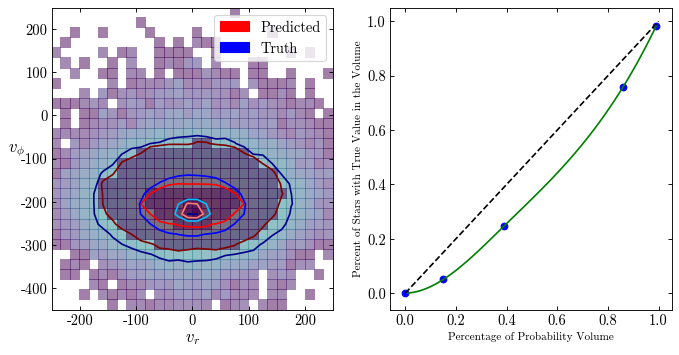

In [77]:
plot_contours(ellipse_df)

(100, 100)


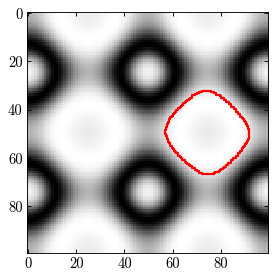

In [187]:
import numpy as np
import matplotlib.pyplot as plt
from skimage import measure

# Construct some test data
x, y = np.ogrid[-np.pi:np.pi:100j, -np.pi:np.pi:100j]
r = np.sin(np.exp((np.sin(x)**2 + np.cos(y)**2)))
print(r.shape)
# Find contours at a constant value of 0.8
contours = measure.find_contours(r, 0.8)

# Select the largest contiguous contour
contour = sorted(contours, key=lambda x: len(x))[-1]

# Display the image and plot the contour
fig, ax = plt.subplots()
ax.imshow(r, interpolation='nearest', cmap=plt.cm.gray)
X, Y = ax.get_xlim(), ax.get_ylim()
ax.step(contour.T[1], contour.T[0], linewidth=2, c='r')
#print(contour.T[1])
ax.set_xlim(X), ax.set_ylim(Y)
plt.show()

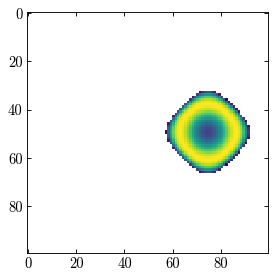

In [181]:
from matplotlib import path
import numpy.ma as ma
import sys
import numpy
numpy.set_printoptions(threshold=sys.maxsize)
closed_path = path.Path(np.array([contour.T[1],contour.T[0]]).T)
#print(closed_path)
#print(r.shape[0])
# Get the points that lie within the closed path
idx = np.array([[(i,j) for i in range(r.shape[0])] for j in range(r.shape[1])]).reshape(np.prod(r.shape),2)
mask = closed_path.contains_points(idx).reshape(r.shape)

# Invert the mask and apply to the image
mask = np.invert(mask)
masked_data = ma.array(r.copy(), mask=mask)
plt.imshow(masked_data)
#print(masked_data)